<a href="https://colab.research.google.com/github/albertsalgueda/tensorflow/blob/main/Exercise_(_RNN_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Google Reviews Exercise*
Calssify google play reviews 

In [2]:
%tensorflow_version 2.x

# IMPORT DEPENDENCIES

In [3]:
import pandas
import tensorflow as tf
import re
import nltk
import numpy

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

nltk.download('stopwords')

tf.__version__

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'2.8.0'

# Upload data
In order to load the data, it can be done in two ways. The first is to upload the csv file in the same runtime environment (Sidebar > Files > Upload). With this mode, every time we leave the notebook it will be deleted. Therefore, we will use the second way: upload it from Google Drive. It will ask us to open a link and enter the code that appears in that link.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Find the path to your file in your google drive

In [6]:
df = pandas.read_csv('/content/drive/My Drive/Tensorflow/data/googleplaystore_user_reviews.csv')

Let's assure that it was uploaded successfully

In [7]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [8]:
df.tail()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64294,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


# Treat the data
this is the most difficult part. 
We should start deleting any sample with a NaN ( for our purpose they are useless )

In [9]:
df = df.dropna()

check that we were successful

In [10]:
df.tail()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
64222,Housing-Real Estate & Property,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667
64223,Housing-Real Estate & Property,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222
64226,Housing-Real Estate & Property,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000
64227,Housing-Real Estate & Property,I property business got link SMS happy perform...,Positive,0.800000,1.000000
64230,Housing-Real Estate & Property,"Useless app, I searched flats kondapur, Hydera...",Negative,-0.316667,0.400000


# Before modeling, understand the data

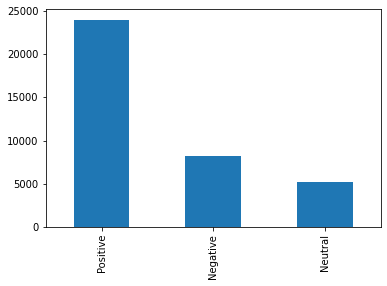

In [12]:
df['Sentiment'].value_counts().plot(kind = 'bar')

In [14]:
#let's bring only the data that we need X_train y_train --> predictor and labels/outcome
df = df[['Translated_Review','Sentiment']]
df.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


Now we could do 2 things: 

A// binary classification --> delete non positve/negative from dataframe

B// Non-binary classification --> 0 1 2

# Text processing
·Lower()

·Delete punctuation signs 

·Delete stop words!!! --> nltk.corpus offers a list of english stop words

In [15]:
def preprocess_text(sen):
    #given a sentence sen outputs a cleaned string

    # Delete symbols and punctuation --> read more about the library re
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Eliminar carácteres sueltos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Eliminar espacios excesivos
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convertir a minúscula
    sentence = sentence.lower()
  
    # Eliminar las stopwords.
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(filtered_words)

Once we created a function to clean our text we have to apply it to all the samples of the dataframe. 

In [17]:
df['Translated_Review'] = df['Translated_Review'].apply(lambda sen: preprocess_text(sen))
df

,Translated_Review,Sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,works great especially going grocery store,Positive
4,best idea us,Positive
5,best way,Positive
...,...,...
64222,ads older many agents much owner posted detail...,Positive
64223,photos posted portal load fit purpose sure sto...,Positive
64226,dumb app wanted post property rent give option...,Negative
64227,property business got link sms happy performan...,Positive


# Vectorial representation of text
let's start with the easy part, turning labels into numeric 

In [18]:
def determine_class(label):
  if label == 'Positive':
    return 0
  elif label == 'Neutral':
    return 1
  elif label == 'Negative':
    return 2

REMOVE_NEUTRAL = False
#consider negative and neutral the same
MERGE_NEGATIVE_NEUTRAL = False

if REMOVE_NEUTRAL:
  #if we take option A...
  indexNames = df[df['Sentiment'] == 'Neutral'].index
  df.drop(indexNames , inplace=True)

  y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
  #y = tf.one_hot(y, 2)
else:
  if MERGE_NEGATIVE_NEUTRAL:
    y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
    #y = tf.one_hot(y, 2)
  else: 
    y = df['Sentiment'].apply(lambda x: determine_class(x)).to_numpy()
    #y = tf.one_hot(y, 3)

X = df['Translated_Review']
y = y.astype(numpy.uint8)

In [19]:
#now we have a dataset with the cleaned sentences
X

0        like eat delicious food cooking food case best...
1               help eating healthy exercise regular basis
3               works great especially going grocery store
4                                             best idea us
5                                                 best way
                               ...                        
64222    ads older many agents much owner posted detail...
64223    photos posted portal load fit purpose sure sto...
64226    dumb app wanted post property rent give option...
64227    property business got link sms happy performan...
64230    useless app searched flats kondapur hyderabad ...
Name: Translated_Review, Length: 37427, dtype: object

In [20]:
#and another one with the labels, in this case we decided to keep the neutral
y

array([0, 0, 0, ..., 2, 0, 2], dtype=uint8)

Split the data into training/testing using: from sklearn.model_selection import train_test_split


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Now we have to determine the maximum number of words ( the n most frequent words )

In [22]:
from keras.preprocessing.text import Tokenizer

We could have also cleaned the text in the tokenizer:

tf.keras.preprocessing.text.Tokenizer(

    num_words=None,

    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',

    lower=True, split=' ', char_level=False, oov_token=None,
    
    document_count=0, **kwargs
)

In [23]:
NUMBER_OF_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Then we use padding for sentences that don't have frequent words. We fill up with 0 the words that don't appear. 

In [34]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

In [46]:
X_train.shape[1]

100

# LSTM Neural Network Design
let's define the paramaters we need

In [44]:
VOCABULARY_SIZE = NUMBER_OF_WORDS
EMBEDDING_SIZE = 128

create a sequential lstm model

In [48]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, 
                                    EMBEDDING_SIZE, 
                                    input_shape=(X_train.shape[1],)))

model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

#We have to specify the number of classes that we have  
model.add(tf.keras.layers.Dense(units=numpy.unique(y_train).shape[0], 
                                activation='sigmoid'))

model.compile(optimizer='rmsprop', 
                loss='sparse_categorical_crossentropy', 
                metrics=['sparse_categorical_accuracy'])
  
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


Let's fit the model to the training data and evaluate its performance on the test data

In [49]:
model.fit(X_train, y_train, epochs=3, batch_size=128)

Epoch 1/3
234/234 [==============================] - 130s 545ms/step - loss: 0.8980 - sparse_categorical_accuracy: 0.6403
Epoch 2/3
234/234 [==============================] - 92s 394ms/step - loss: 0.8930 - sparse_categorical_accuracy: 0.6417
Epoch 3/3
234/234 [==============================] - 92s 393ms/step - loss: 0.8926 - sparse_categorical_accuracy: 0.6417


In [50]:
train_loss, train_accuracy = model.evaluate(X_train,y_train)
test_loss, test_acurracy = model.evaluate(X_test, y_test)
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_acurracy))
print("Bias: {}".format(train_accuracy-test_acurracy))

234/234 [==============================] - 8s 34ms/step - loss: 0.8955 - sparse_categorical_accuracy: 0.6391
Train accuracy: 0.6418957114219666
Test accuracy: 0.6390596032142639
Bias: 0.0028361082077026367
